## Load dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import pickle
import json
import matplotlib.pyplot as plt
from lstm import LSTM_Simple
from metrics import exact_match_metric
from callbacks import NValidationSetsCallback, GradientLogger
from generator import DataGenerator, DataGeneratorSeq
from tqdm import tqdm
from evaluate_lstm import LSTM_Evaluator

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

2.0.0-alpha0
GPU Available:  True


## Plotting Function

In [60]:
def plot_two_results(result_1, result_2=None, experiments=['L&L']):
    labels = []
    array_1 = []
    array_2 = []
    
    for module in result_1:
        labels.append(module.split('__')[1])
        array_1.append(result_1[module])

    if result_2 is not None:
        for module in result_1:
            array_2.append(result_2[module])

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    if result_2 is not None:
        rects1 = ax.bar(x - width/2, array_1, width, label=experiments[0])
        rects2 = ax.bar(x + width/2, array_2, width, label=experiments[1])
    else:
        rects1 = ax.bar(x, array_1, width, label=experiments[0])


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by group and gender')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    if result_2 is not None:
        autolabel(rects2)

    autolabel(rects1)

    fig.tight_layout()

    plt.show()

## Load datasets

In [61]:
model_path = Path('../../models/js0kldpwp1nhos/')

In [62]:
settings_path = model_path/'settings.json'

with open(str(settings_path), 'r') as file:
    settings_dict = json.load(file)


raw_path = Path(settings_dict['data_path'])
interpolate_path = raw_path/'interpolate'
extrapolate_path = raw_path/'extrapolate'
train_easy_path = raw_path/'train-easy/'

settings_dict

{'batch_size': 1024,
 'data_path': '/storage/git/deep-math/data/raw/v1.0/',
 'epochs': 1,
 'latent_dim': 2048,
 'math_module': 'arithmetic',
 'save_path': '/artifacts/',
 'saved_model': '/storage/artifacts/j4bu146wamlr9/model.h5',
 'thinking_steps': 16,
 'train_level': '*'}

In [5]:
def concatenate_texts_individual(path, pattern):
    file_paths = list(path.glob('{}*.txt'.format(pattern)))
    
    input_texts = {}
    target_texts = {}

    for file_path in file_paths:
        if file_path.stem not in input_texts:
            input_texts[file_path.stem] = []
            target_texts[file_path.stem] = []
        
        with open(str(file_path), 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')[:-1]

        input_texts[file_path.stem].extend(lines[0::2])
        target_texts[file_path.stem].extend(['\t' + target_text + '\n' for target_text in lines[1::2]])
        
    return input_texts, target_texts

In [6]:
math_module = settings_dict["math_module"]
train_level = settings_dict["train_level"]

datasets = {
    'train':(raw_path, 'train-' + train_level + '/' + math_module),
    'interpolate':(interpolate_path, math_module),
    'extrapolate':(extrapolate_path, math_module)
           }

input_texts = {}
target_texts = {}

for k, v in datasets.items():
    input_texts[k], target_texts[k] = concatenate_texts_individual(v[0], v[1])
    print('Length of set {} is {}'.format(k, len(input_texts[k])))

Length of set interpolate is 9
Length of set extrapolate is 6
Length of set train is 9


In [7]:
for key in input_texts['extrapolate']:
    print(key)

arithmetic__add_or_sub_big
arithmetic__add_sub_multiple_longer
arithmetic__mul_big
arithmetic__mixed_longer
arithmetic__mul_div_multiple_longer
arithmetic__div_big


In [8]:
for key in input_texts['interpolate']:
    print(key)

arithmetic__add_sub_multiple
arithmetic__mul
arithmetic__add_or_sub
arithmetic__mul_div_multiple
arithmetic__add_or_sub_in_base
arithmetic__mixed
arithmetic__div
arithmetic__simplify_surd
arithmetic__nearest_integer_root


## Evaluate datasets

In [13]:
lstm_eval = LSTM_Evaluator(model_path)

In [14]:
test_sample=1024

extrapolate arithmetic__add_or_sub_big
78/78 [==============================] - 21s 263ms/step - loss: 0.0605 - exact_match_metric: 0.1986
metric: 0.19861779 

extrapolate arithmetic__add_sub_multiple_longer
78/78 [==============================] - 25s 316ms/step - loss: 0.0400 - exact_match_metric: 0.1559
metric: 0.15594952 

extrapolate arithmetic__mul_big
78/78 [==============================] - 16s 210ms/step - loss: 0.1319 - exact_match_metric: 0.2213
metric: 0.221254 

extrapolate arithmetic__mixed_longer
78/78 [==============================] - 26s 337ms/step - loss: 0.0576 - exact_match_metric: 0.0240
metric: 0.024038462 

extrapolate arithmetic__mul_div_multiple_longer
78/78 [==============================] - 26s 334ms/step - loss: 0.0447 - exact_match_metric: 0.2556
metric: 0.25560898 

extrapolate arithmetic__div_big
78/78 [==============================] - 15s 187ms/step - loss: 0.0880 - exact_match_metric: 0.4732
metric: 0.47315705 



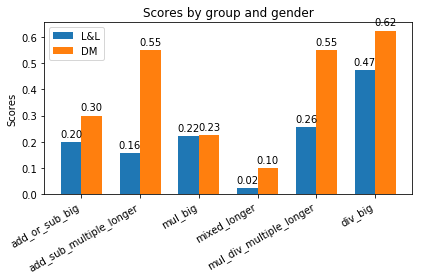

In [63]:
test_set = 'extrapolate'
results = {}

results_deepmind = {'arithmetic__add_or_sub_big': 0.3,
                    'arithmetic__add_sub_multiple_longer': 0.55,
                    'arithmetic__mul_big': .225,
                    'arithmetic__mixed_longer': 0.1,
                    'arithmetic__mul_div_multiple_longer': 0.55,
                    'arithmetic__div_big':0.625}

for module in input_texts[test_set]:
    print(test_set, module)
    metric = lstm_eval.evaluate_model(input_texts[test_set][module], target_texts[test_set][module])
    print('metric:', metric, '\n')
    results[module] = metric
    
plot_two_results(results, results_deepmind, experiments=['L&L', 'DM'])

interpolate arithmetic__add_sub_multiple
78/78 [==============================] - 18s 230ms/step - loss: 0.0110 - exact_match_metric: 0.6514
metric: 0.6514423 

interpolate arithmetic__mul
78/78 [==============================] - 15s 196ms/step - loss: 0.0579 - exact_match_metric: 0.4368
metric: 0.43679887 

interpolate arithmetic__add_or_sub
78/78 [==============================] - 18s 230ms/step - loss: 0.0085 - exact_match_metric: 0.7886
metric: 0.7885617 

interpolate arithmetic__mul_div_multiple
78/78 [==============================] - 20s 255ms/step - loss: 0.0038 - exact_match_metric: 0.8644
metric: 0.86438304 

interpolate arithmetic__add_or_sub_in_base
78/78 [==============================] - 20s 255ms/step - loss: 0.0049 - exact_match_metric: 0.8550
metric: 0.85496795 

interpolate arithmetic__mixed
78/78 [==============================] - 20s 258ms/step - loss: 0.0256 - exact_match_metric: 0.3830
metric: 0.38301283 

interpolate arithmetic__div
78/78 [=======================

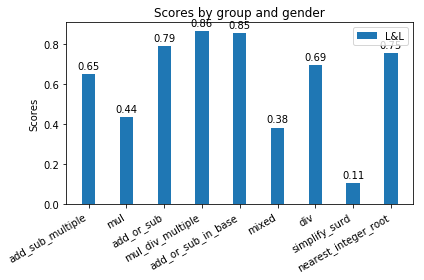

In [65]:
test_set = 'interpolate'
results = {}

results_deepmind = {'arithmetic__add_or_sub': 0.875,
                    'arithmetic__add_or_sub_in_base': 0.9,
                    'arithmetic__add_sub_multiple': .95,
                    'arithmetic__mul_div_multiple': .95,
                    'arithmetic__nearest_integer_root': .875,
                    'arithmetic__mul': 0.45,
                    'arithmetic__div': 0.78,
                    'arithmetic__simplify_surd':0.16,
                    'arithmetic__mixed': 0.62}

for module in input_texts[test_set]:
    print(test_set, module)
    metric = lstm_eval.evaluate_model(input_texts[test_set][module], target_texts[test_set][module])
    print('metric:', metric, '\n')
    results[module] = metric
    
plot_two_results(results, results_deepmind experiments=['L&L', 'DM'])

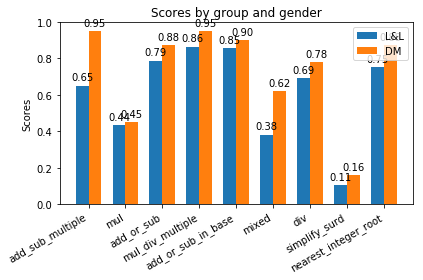

In [67]:
plot_two_results(results, results_deepmind, experiments=['L&L', 'DM'])

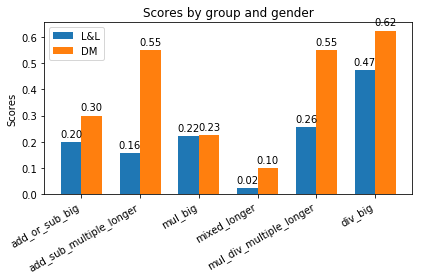

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np




6 6 6
6 6 6


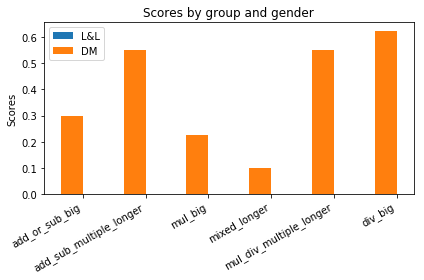

In [36]:
plot_comparison([results, results_deepmind], ['L&L', 'DM'])

## We can also test an indiviual string:

In [29]:
lstm_eval.predict_on_string('1 / 7')

'-4'

In [52]:
lstm_eval.predict_on_string('2*2')

''